# Figure 011 (v001)

Model covariance matrices.

## Setup

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from math import ceil

import janitor  # noqa: F401
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
from speclet.io import figure_img_file, tables_dir
from speclet.plot import PlottingMode, set_speclet_theme

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
set_speclet_theme(PlottingMode.DISSERTATION)
np.random.seed(0)

In [5]:
FIGNUM, VERSION = 11, 1
FIGSIZE = (6.5, 7.5)

In [6]:
nb_output_dir = tables_dir() / "100_120_cancer-gene-comut-analysis"

### Data

In [7]:
gene_effect_corrs = pd.read_csv(
    nb_output_dir / "gene-effect-covariance-posteriors.csv"
).sort_values("lineage_subtype")

## Figure

In [8]:
def short_cancers(t: str) -> str:
    replacements = {"adenocarcinoma": "adeno.", "carcinoma": "carc."}
    for k, v in replacements.items():
        t = t.replace(k, v)
    return t


def extract_subtype(t: str, shorten: bool = True) -> str:
    if "(" not in t:
        return t
    t = t.split("(")[1].replace(")", "").strip()
    if shorten:
        t = short_cancers(t)
    return t

In [9]:
def make_gene_correlation_matrix_figure(
    data: pd.DataFrame, n_cols: int
) -> tuple[plt.Figure, plt.Axes]:
    figure = plt.figure(figsize=FIGSIZE, tight_layout=True)
    n_axes = data["lineage_subtype"].nunique()
    n_rows = ceil(n_axes / n_cols)

    axes = figure.subplots(nrows=n_rows, ncols=n_cols)
    for ax, (ln, df_ln) in zip(axes.flatten(), data.groupby("lineage_subtype")):
        ax.set_title(extract_subtype(ln, shorten=True), pad=3, size=6)
        _vars = ["mu_a", "b", "d", "f"]
        _vars += [v for v in df_ln["var1"].unique() if "h_" in v]
        var_names = {}
        for i, v in enumerate(_vars):
            if v == "mu_a":
                var_names[v] = r"$\mu_a$"
            elif "h_" in v:
                gene = v.split("_")[1]
                var_names[v] = "$h_{" + gene + "}$"
            else:
                var_names[v] = f"${v}$"
        _var_names_cat = list(var_names.values())
        df_ln = (
            df_ln.copy()
            .assign(
                var1=lambda d: d["var1"].map(var_names),
                var2=lambda d: d["var2"].map(var_names),
            )
            .assign(
                var1=lambda d: pd.Categorical(d["var1"], categories=_var_names_cat),
                var2=lambda d: pd.Categorical(d["var2"], categories=_var_names_cat),
            )
        )
        X = df_ln.pivot_wider("var1", names_from="var2", values_from="mean").set_index(
            "var1"
        )
        sns.heatmap(
            data=X,
            square=True,
            ax=ax,
            cmap="coolwarm",
            center=0,
            vmin=-1,
            vmax=1,
            cbar=False,
        )
        ax.tick_params("x", rotation=90)
        ax.tick_params("y", rotation=0)
        ax.set_xticks(
            np.arange(len(_var_names_cat)) + 1,
            labels=_var_names_cat,
            rotation=70,
            ha="right",
        )
        ax.set_yticks(
            np.arange(len(_var_names_cat)) + 0.5, labels=_var_names_cat, va="center"
        )
        ax.tick_params(pad=0, labelsize=6)
        ax.set_xlabel(None)
        ax.set_ylabel(None)

    for ax in axes.flatten()[n_axes:]:
        ax.axis("off")

    return figure, axes

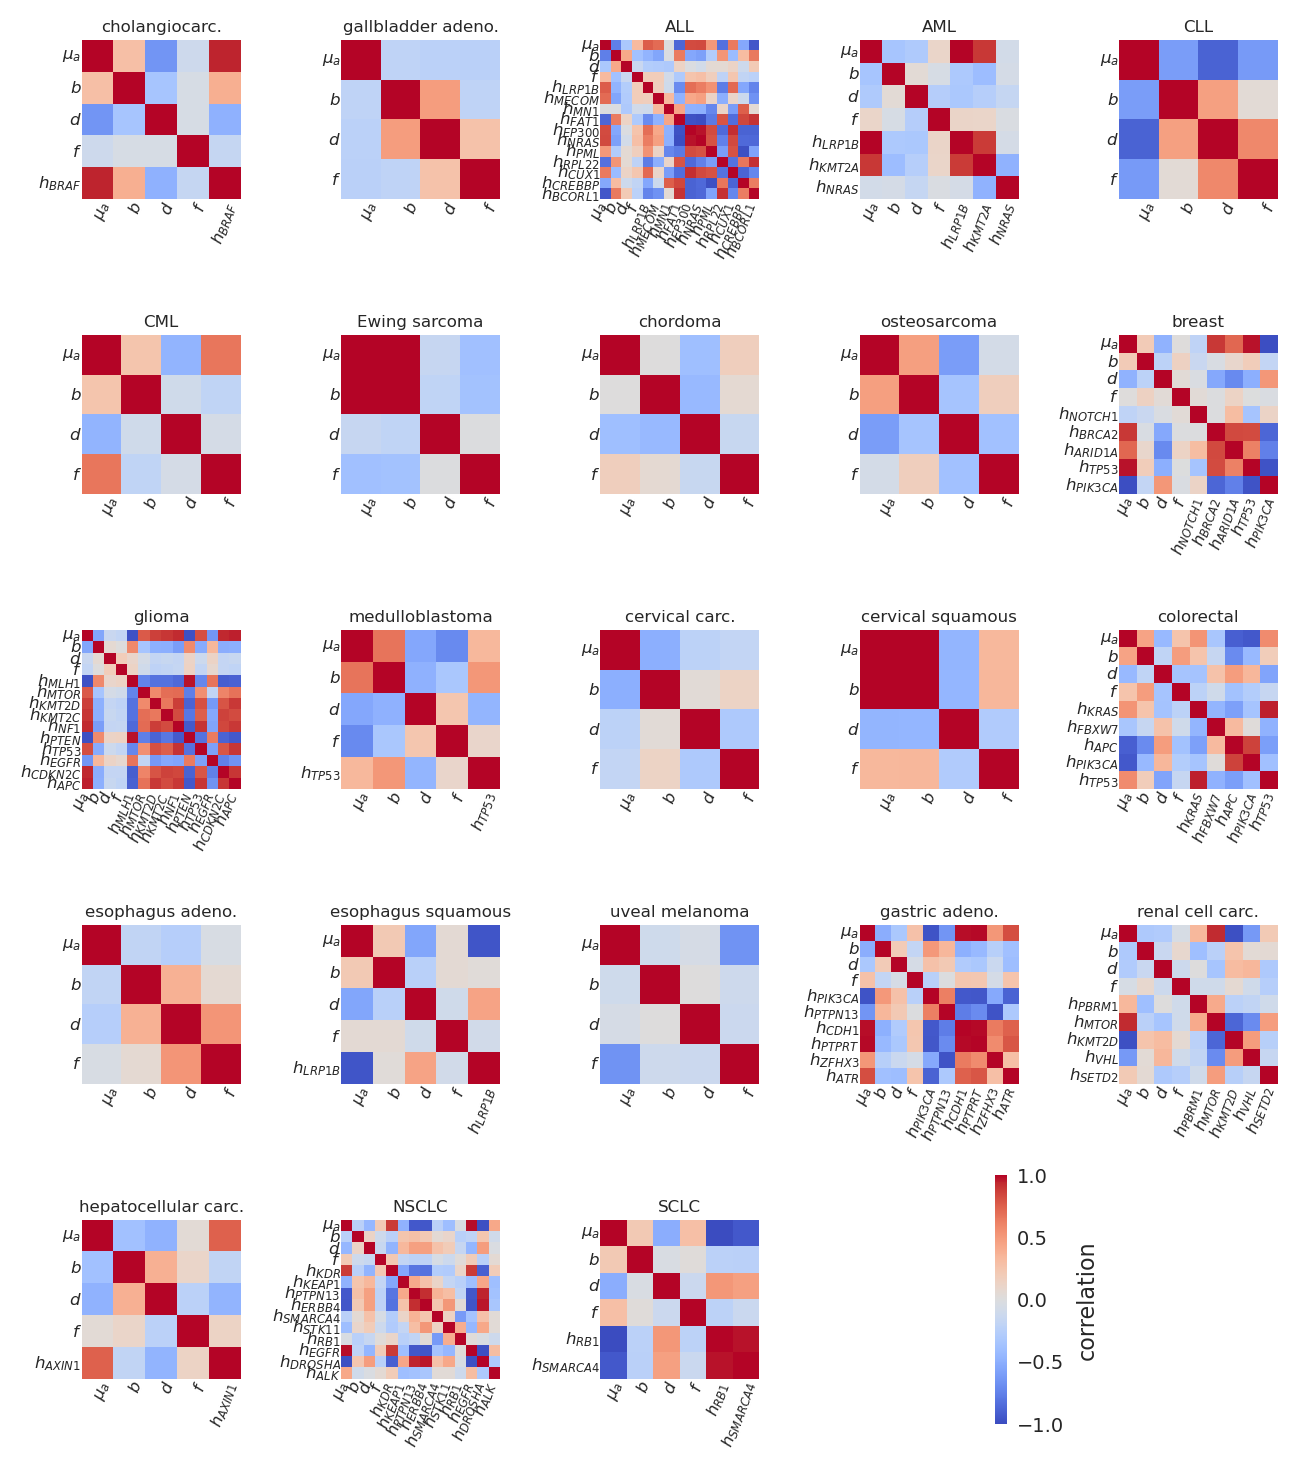

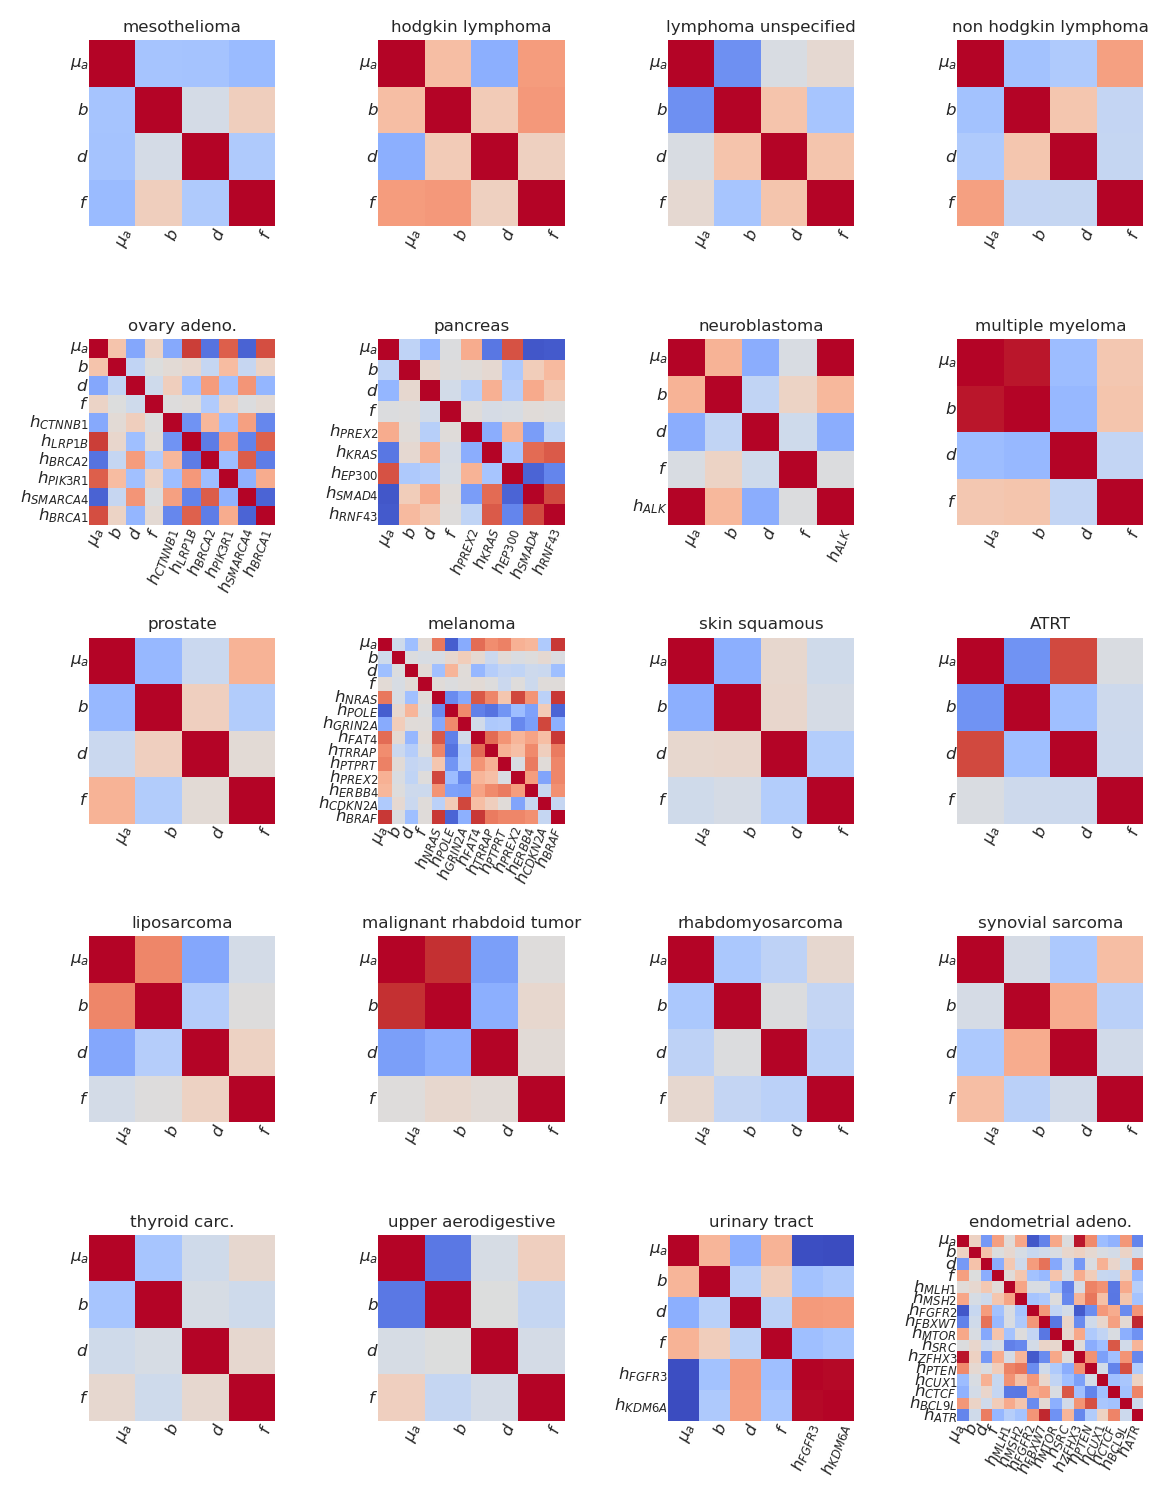

In [11]:
lineage_subtypes = gene_effect_corrs["lineage_subtype"].unique()
sep = round(len(lineage_subtypes) / 2) + 1
fig1, axes1 = gene_effect_corrs.filter_column_isin(
    "lineage_subtype", lineage_subtypes[:sep]
).pipe(make_gene_correlation_matrix_figure, n_cols=5)

cmap = sns.color_palette("coolwarm", as_cmap=True)
norm = mpl.colors.Normalize(vmin=-1, vmax=1)

cbar_ax = axes1.flatten()[-2]
cbar_ax.axis("off")
cbar = fig1.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=cbar_ax,
    orientation="vertical",
    label="correlation",
)
cbar.outline.set_visible(False)
fig1.savefig(
    figure_img_file(FIGNUM, VERSION, "model-covariance-matrices-1"),
    dpi=400,
    pad_inches=0,
    bbox_inches="tight",
)


fig2, _ = gene_effect_corrs.filter_column_isin(
    "lineage_subtype", lineage_subtypes[sep:]
).pipe(
    make_gene_correlation_matrix_figure,
    n_cols=4,
)
fig2.savefig(
    figure_img_file(FIGNUM, VERSION, "model-covariance-matrices-2"),
    dpi=400,
    pad_inches=0,
    bbox_inches="tight",
)

---

## Session Info

In [12]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-10-11

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : GCC 10.4.0
OS          : Linux
Release     : 3.10.0-1160.76.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Hostname: compute-a-16-170.o2.rc.hms.harvard.edu

Git branch: figures

seaborn   : 0.11.2
pandas    : 1.4.4
numpy     : 1.23.3
matplotlib: 3.5.3
janitor   : 0.22.0

